# Picocoder
_A Raspberry Pi Pico microcode glitcher_

## Connection
We connect with the Pi Pico and setup some glitching options.

In [1]:
%matplotlib widget

POWERSUPPLY_PORT = '/dev/ttyACM0'
GLITCHER_PORT = '/dev/ttyACM1'
GLITCHER_BAUD = 115200

import pathlib
import sys
import os
import matplotlib.pyplot as plt
from importlib import reload # for debugging
from tqdm.notebook import tqdm

# sys.path.append(str(pathlib.Path(os.getcwd()).parent))

import picocoder_client
from picocoder_client import Picocoder, GlitchResult
from picocoder_client import PowerSupply, KA3305P
glitch_utils = reload(picocoder_client)

try:
	del ps
	del glitcher
	del gc
except:
	pass
ps = KA3305P(port=POWERSUPPLY_PORT, cycle_wait=0.5)
ps.con()
ps.power_cycle()

glitcher = Picocoder(GLITCHER_PORT, GLITCHER_BAUD)
if not glitcher.ping():
	raise Exception("Glitcher not responding")
# if not glitcher.ping_target(): # Commented out as it does not play well with ucode-related stuff that is way slower than my payloads
# 	raise Exception("Target not responding")

def reset_target(ps: PowerSupply, glitcher: Picocoder) -> None:
	ps.power_cycle()
	if not glitcher.ping_target():
		raise Exception("Target not responding after reset")

ModuleNotFoundError: No module named 'ipympl'

## Measure the duration of opcode loop
We obtain an estimate (in us) of the loop where the opcode is executed, which
is an upper bound for ext_offset+width.

This is calculated by measuring the number of microseconds between two
consecutive bytes received by the glitcher from the t arget, and subtracting
the time between the first UART pulse appears on the channel, and when the
glitcher detects an incoming byte. It is therefore expected to be less than
the actual duration of the opcode loop.

In [2]:
max_total_duration = glitcher.measure_loop_duration()
if max_total_duration < 0:
	raise Exception(f'Invalid duration {max_total_duration}')
print(f"Measured total duration: {max_total_duration}")

Measured total duration: 383


## Measure UART delay
This command is used to measure (externally) the time it takes for the Pico to
detect data on the UART RX pin and to start processing it. <br>
The debug pin (GPIO 16, shown blue) is toggled when the Pico detects data.

![Oscilloscope capture](../firmware/inject_v2/img/fast_response_time_busy_wait_on_UART_with_timeout.png)

In [ ]:
glitcher.uart_toggle_debug_pin()

## Estimate $V_p$ for `cmp`

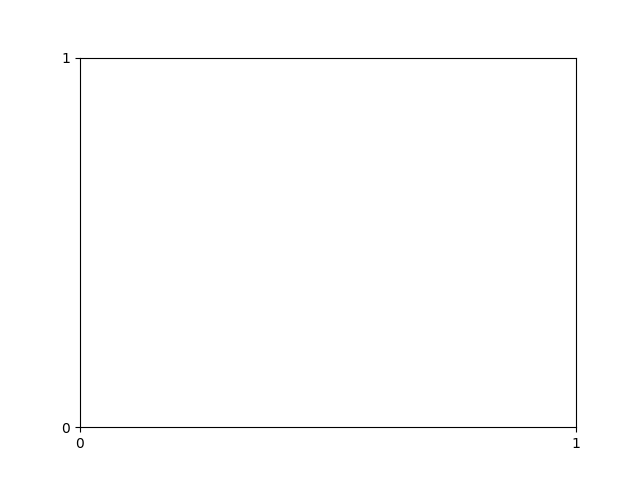

In [3]:
glitcher.tc = picocoder_client.TargetCmp()
gc_vp_cmp = glitch_utils.GlitchControllerTPS65094(groups=[r.name for r in GlitchResult], parameters=['ext_offset', 'width', 'voltage', 'prep_voltage'], nominal_voltage=1.24) # Nominal voltage after boot completes
gc_vp_cmp.set_range('ext_offset', 90, 150)
gc_vp_cmp.set_range('width', 10, 30)
gc_vp_cmp.set_range('prep_voltage', 36, 40)
gc_vp_cmp.set_range('voltage', 33, 35)

gc_vp_cmp.draw_graph('ext_offset', 'prep_voltage')

In [5]:
for gs in gc_vp_cmp.rand_glitch_values():
	try:
		result, data = glitcher.glitch(gs)
		gc_vp_cmp.add_result(gs, result, data)

		if result == GlitchResult.WEIRD:
			print(f'Got weird response: 0x{data.hex()}') # type: ignore
		if result in [GlitchResult.RESET, GlitchResult.BROKEN, GlitchResult.HALF_SUCCESS]:
			reset_target(ps, glitcher)
	except KeyboardInterrupt:
		gc_vp_cmp.redraw_graph()
		break # Gentle stop, otherwise the plot might look empty

## Glitch `cmp`

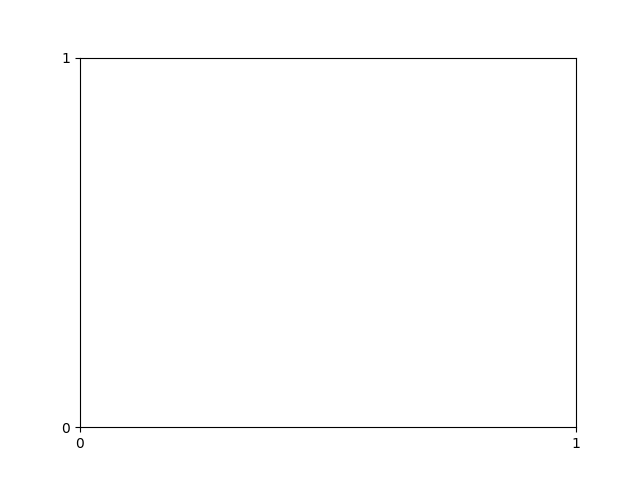

In [6]:
glitcher.tc = picocoder_client.TargetCmp()
gc_cmp = glitch_utils.GlitchControllerTPS65094(groups=[r.name for r in GlitchResult], parameters=['ext_offset', 'width', 'voltage', 'prep_voltage'], nominal_voltage=1.24) # Nominal voltage after boot completes
gc_cmp.set_range('ext_offset', 90, 150)
gc_cmp.set_range('width', 10, 30)
gc_cmp.set_range('voltage', 35, 35)
gc_cmp.set_range('prep_voltage', 36, 36)

gc_cmp.draw_graph('width', 'voltage')

In [7]:
BREAK_ON_HALF_SUCCESS = False
BREAK_ON_SUCCESS = False
for gs in gc_cmp.rand_glitch_values():
	try:
		result, data = glitcher.glitch(gs)
		gc_cmp.add_result(gs, result, data)

		if result == GlitchResult.WEIRD:
			print(f'Got weird response: 0x{data.hex()}') # type: ignore
		if result in [GlitchResult.RESET, GlitchResult.BROKEN, GlitchResult.HALF_SUCCESS]:
			reset_target(ps, glitcher)
	except KeyboardInterrupt:
		gc_cmp.redraw_graph()
		break # Gentle stop, otherwise the plot might look empty

## Ucode update timings
**NOTE**: the target must be flashed with `TARGET_UCODE_UPDATE_TIME` for this to work

In [3]:
import struct
ALWAYS_POWER_CYCLE = False

times = []
if ALWAYS_POWER_CYCLE:
	ps.power_cycle()
glitcher.s.write(picocoder_py.P_CMD_UART_ECHO)
old_timeout = glitcher.s.timeout
glitcher.s.timeout = 0.5
for i in tqdm(range(1000)):
	glitcher.s.reset_input_buffer()
	glitcher.s.read_until(b'RD')
	data = glitcher.s.read(9) # <uint32_t> | <uint32_t> | `R`
	if len(data) != 9:
		print(f'Got short response: 0x{data.hex()}')
		continue
	ucode_rev, ucode_update_time, ready = struct.unpack('<IIB', data)
	if ready != 0x52: # `R`
		print(f'Got weird response: 0x{data.hex()}')
		print(f'ucode_rev: {ucode_rev}, ucode_update_time: {ucode_update_time}, ready: {ready}')
		from hexdump import hexdump
		hexdump(data)
		break
	times.append(ucode_update_time)
	if ALWAYS_POWER_CYCLE:
		ps.power_cycle()
		glitcher.s.reset_input_buffer()
assert len(times) > 0

times.sort()
print(f'Average time: {sum(times) / len(times)}')
print(f'Median time: {times[len(times) // 2]}')
print(f'[!] Don\'t forget to power flush the glitcher (it\'s stuck in UART echo mode)')
glitcher.s.timeout = old_timeout

  0%|          | 0/1000 [00:00<?, ?it/s]

Average time: 6050049.921
Median time: 6049610
[!] Don't forget to power flush the glitcher (it's stuck in UART echo mode)


# TODO FINISH PORTING TO NEW CODE

## Estimate $V_p$ for `mul`

In [ ]:
glitcher.tc = 'mul'
gc_vp_mul = glitch_utils.GlitchControllerTPS65094(groups=[r.name for r in GlitchResult], parameters=['ext_offset', 'width', 'voltage', 'prep_voltage'], nominal_voltage=1.24) # Nominal voltage after boot completes
gc_vp_mul.set_range('ext_offset', 90, 150) # 477-250, 477-200 working with muls
gc_vp_mul.set_range('width', 61, 61)
gc_vp_mul.set_range('prep_voltage', 0b0011010, 0b0101010) # 0.91V - See Table 6-3 in TPS65094 datasheet
gc_vp_mul.set_range('voltage', 0b1000111, 0b1000111) # 1.2V - See Table 6-3 in TPS65094 datasheet

gc_vp_mul.draw_graph('ext_offset', 'prep_voltage')

In [ ]:
BREAK_ON_HALF_SUCCESS = False
BREAK_ON_SUCCESS = False
for gs in gc_vp_mul.rand_glitch_values():
	try:

		result, read_data = glitcher.glitch_mul(gs)
		gc_vp_mul.add_result(gs, result, read_data)

		if result == GlitchResult.WEIRD:
			print(f'Got weird response: 0x{read_data.hex()}')
		if result == GlitchResult.HALF_SUCCESS:
			# print(f'HALF SUCCESS!')
			# print(f'\tParameters: prep_voltage {glitcher.prep_voltage}, ext_offset {gs["ext_offset"]}, width {gs["width"]} and voltage {gs["voltage"]}')
			if BREAK_ON_HALF_SUCCESS:
				break # Stop before reset, so we can see on the oscilloscope
		if result == GlitchResult.SUCCESS:
			[successes, result_a, result_b] = read_data
			print(f'SUCCESS! With {successes} successful glitche(s), {result_a} != {result_b}')
			print(f'\tParameters: prep_voltage {glitcher.prep_voltage}, ext_offset {gs["ext_offset"]}, width {gs["width"]} and voltage {gs["voltage"]}')
			if BREAK_ON_SUCCESS:
				break

		if result in [GlitchResult.RESET, GlitchResult.BROKEN, GlitchResult.HALF_SUCCESS]:
			reset_target(ps, glitcher)
	except KeyboardInterrupt:
		gc_vp_mul.redraw_graph()
		break # Gentle stop, otherwise the plot might look empty

## Glitch `mul`

In [ ]:
gc_mul = glitch_utils.GlitchControllerTPS65094(groups=[r.name for r in GlitchResult], parameters=['ext_offset', 'width', 'voltage', 'prep_voltage'], nominal_voltage=1.24) # Nominal voltage after boot completes
gc_mul.set_range('ext_offset', 10, 100) # 477-250, 477-200 working with muls
gc_mul.set_range('width', 1, 100)
gc_mul.set_range('voltage', 28, 34) # 0.79V-0.83V - See Table 6-3 in TPS65094 datasheet
gc_mul.set_range('prep_voltage', 0b0101010, 0b0101010) # 0.91V - See Table 6-3 in TPS65094 datasheet

gc_mul.draw_graph('width', 'voltage')

In [ ]:
BREAK_ON_HALF_SUCCESS = False
BREAK_ON_SUCCESS = False
for gs in gc_mul.rand_glitch_values():
	try:

		result, read_data = glitcher.glitch_mul(gs)
		gc_mul.add_result(gs, result, read_data)

		if result == GlitchResult.WEIRD:
			print(f'Got weird response: 0x{read_data.hex()}')
		if result == GlitchResult.HALF_SUCCESS:
			# print(f'HALF SUCCESS!')
			# print(f'\tParameters: prep_voltage {glitcher.prep_voltage}, ext_offset {gs["ext_offset"]}, width {gs["width"]} and voltage {gs["voltage"]}')
			if BREAK_ON_HALF_SUCCESS:
				break # Stop before reset, so we can see on the oscilloscope
		if result == GlitchResult.SUCCESS:
			[successes, result_a, result_b] = read_data
			print(f'SUCCESS! With {successes} successful glitche(s), {result_a} != {result_b}')
			print(f'\tParameters: prep_voltage {glitcher.prep_voltage}, ext_offset {gs["ext_offset"]}, width {gs["width"]} and voltage {gs["voltage"]}')
			if BREAK_ON_SUCCESS:
				break

		if result in [GlitchResult.RESET, GlitchResult.BROKEN, GlitchResult.HALF_SUCCESS]:
			reset_target(ps, glitcher)
	except KeyboardInterrupt:
		gc_mul.redraw_graph()
		break # Gentle stop, otherwise the plot might look empty

## Estimate $V_p$ for `load`

In [ ]:
glitcher.tc = 'load'
gc_vp_load = glitch_utils.GlitchControllerTPS65094(groups=[r.name for r in GlitchResult], parameters=['ext_offset', 'width', 'voltage', 'prep_voltage'], nominal_voltage=1.24) # Nominal voltage after boot completes
gc_vp_load.set_range('ext_offset', 90, 150) # 477-250, 477-200 working with muls
gc_vp_load.set_range('width', 61, 61)
gc_vp_load.set_range('prep_voltage', 0b0011010, 0b0101010) # 0.91V - See Table 6-3 in TPS65094 datasheet
gc_vp_load.set_range('voltage', 0b1000111, 0b1000111) # 1.2V - See Table 6-3 in TPS65094 datasheet

gc_vp_load.draw_graph('ext_offset', 'prep_voltage')

In [ ]:
BREAK_ON_HALF_SUCCESS = False
BREAK_ON_SUCCESS = False
for gs in gc_vp_load.rand_glitch_values():
	try:

		result, read_data = glitcher.glitch_load(gs)
		gc_vp_load.add_result(gs, result, read_data)

		if result == GlitchResult.WEIRD:
			print(f'Got weird response: 0x{read_data.hex()}')
		if result == GlitchResult.HALF_SUCCESS:
			# print(f'HALF SUCCESS!')
			# print(f'\tParameters: prep_voltage {glitcher.prep_voltage}, ext_offset {gs["ext_offset"]}, width {gs["width"]} and voltage {gs["voltage"]}')
			if BREAK_ON_HALF_SUCCESS:
				break # Stop before reset, so we can see on the oscilloscope
		if result == GlitchResult.SUCCESS:
			successes = read_data
			print(f'SUCCESS! With {successes} successful glitche(s)')
			print(f'\tParameters: prep_voltage {glitcher.prep_voltage}, ext_offset {gs["ext_offset"]}, width {gs["width"]} and voltage {gs["voltage"]}')
			if BREAK_ON_SUCCESS:
				break

		if result in [GlitchResult.RESET, GlitchResult.BROKEN, GlitchResult.HALF_SUCCESS]:
			reset_target(ps, glitcher)
	except KeyboardInterrupt:
		gc_vp_load.redraw_graph()
		break # Gentle stop, otherwise the plot might look empty

## Glitch `load`

In [ ]:
gc_load = glitch_utils.GlitchControllerTPS65094(groups=[r.name for r in GlitchResult], parameters=['ext_offset', 'width', 'voltage', 'prep_voltage'], nominal_voltage=1.24) # Nominal voltage after boot completes
gc_load.set_range('ext_offset', 90, 150) # 477-250, 477-200 working with muls
gc_load.set_range('width', 1, 20)
gc_load.set_range('voltage', 35, 35)
gc_load.set_range('prep_voltage', 36, 36)

gc_load.draw_graph('width', 'voltage')

In [ ]:
BREAK_ON_HALF_SUCCESS = False
BREAK_ON_SUCCESS = True
for gs in gc_load.rand_glitch_values():
	try:

		result, read_data = glitcher.glitch_load(gs)
		gc_load.add_result(gs, result, read_data)

		if result == GlitchResult.WEIRD:
			print(f'Got weird response: 0x{read_data.hex()}')
		if result == GlitchResult.HALF_SUCCESS:
			# print(f'HALF SUCCESS!')
			# print(f'\tParameters: prep_voltage {glitcher.prep_voltage}, ext_offset {gs["ext_offset"]}, width {gs["width"]} and voltage {gs["voltage"]}')
			if BREAK_ON_HALF_SUCCESS:
				break # Stop before reset, so we can see on the oscilloscope
		if result == GlitchResult.SUCCESS:
			(successes, wrong_value) = read_data
			print(f'SUCCESS! With {successes} successful glitche(s). Last recorded wrong value was 0x{wrong_value:02X}')
			print(f'\tParameters: prep_voltage {glitcher.prep_voltage}, ext_offset {gs["ext_offset"]}, width {gs["width"]} and voltage {gs["voltage"]}')
			if BREAK_ON_SUCCESS:
				break

		if result in [GlitchResult.RESET, GlitchResult.BROKEN, GlitchResult.HALF_SUCCESS]:
			reset_target(ps, glitcher)
	except KeyboardInterrupt:
		gc_load.redraw_graph()
		break # Gentle stop, otherwise the plot might look empty

### Additional plot
We can now separate the 3 VID levels we tested and see how the target behaves.
Here we plot all the glitches, clustering them in 3 main groups:
- green: normal operation
- yellow: reset, weird, half success and broken
- red: successful glitch

In [ ]:
%matplotlib inline
plt.clf()

fig, ax = plt.subplots(ncols=2, nrows=2, layout="tight")
ax[0, 0].set_title('VID 34')
ax[0, 1].set_title('VID 35')
ax[1, 0].set_title('VID 36')

simplify_color = { # Go from 6 different markers/colors to 3 for better visibility once we have a lot of data
	GlitchResult.RESET					: 'sy', # Yellow
	GlitchResult.NORMAL					: 'sg', # Green
	GlitchResult.WEIRD					: 'sy', # Yellow
	GlitchResult.SUCCESS				: 'sr', # Red
	GlitchResult.HALF_SUCCESS			: 'sy', # Yellow
	GlitchResult.BROKEN					: 'sy', # Yellow
}

for glitch_values, result in gc_load.results:
	if glitch_values['voltage'] == 34:
		ax[0, 0].plot(glitch_values['width'], glitch_values['ext_offset'], simplify_color[result], alpha=0.1 if result != GlitchResult.SUCCESS else 0.5)
	if glitch_values['voltage'] == 35:
		ax[0, 1].plot(glitch_values['width'], glitch_values['ext_offset'], simplify_color[result], alpha=0.1 if result != GlitchResult.SUCCESS else 0.5)
	if glitch_values['voltage'] == 36:
		ax[1, 0].plot(glitch_values['width'], glitch_values['ext_offset'], simplify_color[result], alpha=0.1 if result != GlitchResult.SUCCESS else 0.5)

And here we only plot non-normal iterations, as we mostly care about where
abnormal behavior happens. We can see from both this and the previous graph
that we are interested in VID 35 and that we want to expand the width range
to the right.

In [ ]:
fig, ax = plt.subplots(ncols=2, nrows=2, layout="tight")
ax[0, 0].set_title('VID 34')
ax[0, 1].set_title('VID 35')
ax[1, 0].set_title('VID 36')

for glitch_values, result in gc_load.results:
	if result == GlitchResult.NORMAL:
		continue
	if glitch_values['voltage'] == 34:
		ax[0, 0].plot(glitch_values['width'], glitch_values['ext_offset'], simplify_color[result], alpha=0.1 if result != GlitchResult.SUCCESS else 0.5)
	if glitch_values['voltage'] == 35:
		ax[0, 1].plot(glitch_values['width'], glitch_values['ext_offset'], simplify_color[result], alpha=0.1 if result != GlitchResult.SUCCESS else 0.5)
	if glitch_values['voltage'] == 36:
		ax[1, 0].plot(glitch_values['width'], glitch_values['ext_offset'], simplify_color[result], alpha=0.1 if result != GlitchResult.SUCCESS else 0.5)

## Estimate $V_p$ for custom microcoded `rcx += rax - rbx`

In [ ]:
glitcher.tc = 'rdrand'
gc_vp_ucode = glitch_utils.GlitchControllerTPS65094(groups=[r.name for r in GlitchResult], parameters=['ext_offset', 'width', 'voltage', 'prep_voltage'], nominal_voltage=1.24) # Nominal voltage after boot completes
gc_vp_ucode.set_range('ext_offset', 150, 200) # 477-250, 477-200 working with muls
gc_vp_ucode.set_range('width', 61, 61)
gc_vp_ucode.set_range('prep_voltage', 0b0011010, 0b0101010) # 0.91V - See Table 6-3 in TPS65094 datasheet
gc_vp_ucode.set_range('voltage', 0b1000111, 0b1000111) # 1.2V - See Table 6-3 in TPS65094 datasheet

gc_vp_ucode.draw_graph('ext_offset', 'prep_voltage')

In [ ]:
BREAK_ON_HALF_SUCCESS = False
BREAK_ON_SUCCESS = False
for gs in gc_vp_ucode.rand_glitch_values():
	try:

		result, read_data = glitcher.glitch_cmp(gs)
		gc_vp_ucode.add_result(gs, result, read_data)

		if result == GlitchResult.WEIRD:
			print(f'Got weird response: 0x{read_data.hex()}')
		if result == GlitchResult.HALF_SUCCESS:
			# print(f'HALF SUCCESS!')
			# print(f'\tParameters: prep_voltage {glitcher.prep_voltage}, ext_offset {gs["ext_offset"]}, width {gs["width"]} and voltage {gs["voltage"]}')
			if BREAK_ON_HALF_SUCCESS:
				break # Stop before reset, so we can see on the oscilloscope
		if result == GlitchResult.SUCCESS:
			successes = read_data
			print(f'SUCCESS! With {successes} successful glitche(s)')
			print(f'\tParameters: prep_voltage {glitcher.prep_voltage}, ext_offset {gs["ext_offset"]}, width {gs["width"]} and voltage {gs["voltage"]}')
			if BREAK_ON_SUCCESS:
				break

		if result in [GlitchResult.RESET, GlitchResult.BROKEN, GlitchResult.HALF_SUCCESS]:
			reset_target(ps, glitcher)
	except KeyboardInterrupt:
		gc_vp_ucode.redraw_graph()
		break # Gentle stop, otherwise the plot might look empty